In [1]:
import numpy as np
import pygame
import gymnasium as gym
from gymnasium import spaces
import torch


pygame 2.1.0 (SDL 2.0.16, Python 3.8.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


In this project we'll be writing an algorithm to find the optimal policy for the game 2048. 

We'll be using a Deep Q-Network to learn the optimal policy, as a function of the game state and available actions, First we should figure out how to represent the game state and available actions.

Actions are straightforward to represent, a player may choose to slide the tiles up, left, right, or down, and these actions are available to the player at all times. 

In order to represent state, we first need to know how to represent an individual tile. We know that tiles can take on values of 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, or 2048. That is 2**1 - 2**11. Additionally, tiles can be empty, so we can think of a tile as having 1 of 12 discrete values, which we can represent with a one-hot encoding. Then, we just need a one-hot encoding for each of the 16 tiles on the board.

So, our state-action space is comprised of 12**16 possible states and 4 possible actions. It's not feasible to store all of these states in memory, but we can use a Q-network to approximate the optimal policy.

For now, we can set up the environment without worrying about a visual representation. We can use the state-representation we discussed before to represent the observation space.

In [2]:
from copy import deepcopy
import random

In [3]:
def merge(values, reverse=False):
    index = 0
    direction = 1
    size = len(values)
    if reverse:
        index = size - 1
        direction = -1
    merged = np.zeros(4)
    seen_first = False
    can_combine = False
    m_index = index
    while index >= 0 and index < size:
        if values[index] != 0:
            if can_combine and merged[m_index] == values[index]:
                merged[m_index] += 1
                can_combine = False
            elif values[index] != 0:
                if seen_first:
                    m_index += direction
                    merged[m_index] = values[index]
                    can_combine = True
                else:
                    merged[m_index] = values[index]
                    can_combine = True
                    seen_first = True
                
        index += direction
    return np.array(merged)


class _2048Env(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=4, keep_history=True):
        self.size = size
        self.window_size = 512
        
        self.observation_space = spaces.Tuple(
            [spaces.Tuple([spaces.Discrete(18) for _ in range(self.size)]) for _ in range(self.size)]
        )

        # We can slide in any of the four directions: right, up, left, down.
        self.action_space = spaces.Discrete(4) # 0 == right, 1 == up, 2 == left, 3 == down
        self.board = np.zeros((self.size, self.size), dtype=np.int32)
        self.keep_history = keep_history
        if keep_history:
            self.board_history = []
        else:
            self.board_history = None
    
    def _get_obs(self):
        return tuple(tuple(row) for row in self.board)
    
    def _get_info(self):
        return None

    def reset(self, seed=None, options={}):
        super().reset(seed=seed)

        num_starting_tiles = options.get('starting_tiles', 2)
        self.board = np.zeros((self.size, self.size), dtype=np.int32)
        # choose 2 random indices for the first 2 tiles
        indices = np.random.choice(self.size ** 2, num_starting_tiles, replace=False)
        for index in indices:
            self.board[index//self.size, index%self.size] = 1
        self.board_history = [np.copy(self.board)]
        return self._get_obs(), self._get_info()
    
    def get_legal_actions(self):
        legal_actions = np.zeros(4)
        # segment is un-collapsible if it's strictly decreasing or zero
    
        for pairs in np.lib.stride_tricks.sliding_window_view(self.board, (1, 2)):
            for pair in pairs:
                pair = pair[0]
                if pair[0] == pair[1] and pair[0] != 0:
                    legal_actions[0] = 1
                    legal_actions[2] = 1
                    break
                if pair[0] == 0 and pair[1] != 0:
                    legal_actions[2] = 1
                if pair[1] == 0 and pair[0] != 0:
                    legal_actions[0] = 1
        
        for pairs in np.lib.stride_tricks.sliding_window_view(self.board, (2,1)):
            for pair in pairs:
                pair = [pair[0][0], pair[1][0]]
                if pair[0] == pair[1] and pair[0] != 0:
                    legal_actions[1] = 1
                    legal_actions[3] = 1
                    break
                if pair[0] == 0 and pair[1] != 0:
                    legal_actions[1] = 1
                if pair[1] == 0 and pair[0] != 0:
                    legal_actions[3] = 1
                
        return legal_actions

    def apply_move(self, action):
        # execute action
        reverse = True
        is_rows = True
        if action == 1:
            reverse = False
            is_rows = False
        elif action == 2:
            reverse = False
            is_rows = True
        elif action == 3:
            reverse = True
            is_rows = False

        if is_rows:
            for i in range(self.size):
                self.board[i] = merge(self.board[i], reverse=reverse)
        else:
            for i in range(self.size):
                self.board[:, i] = merge(self.board[:, i], reverse=reverse)

    def step(self, action):
        self.apply_move(action)
    
        terminated = False
        reward = 0
        placement = None

        # choose a random empty spot
        empty = np.argwhere(self.board == 0)
        index = np.random.choice(empty.shape[0], 1)[0]
        value = 2 if random.random() >= 0.9 else 1
        self.board[empty[index, 0], empty[index, 1]] = value
        placement = ((empty[index, 0] * 4) + empty[index, 1], value)

        if np.max(self.get_legal_actions()) == 0:
            terminated = True
            reward = np.log2(np.sum(2 ** self.board))
            
        if self.keep_history:
            self.board_history.append(np.copy(self.board))

        return self._get_obs(), reward, terminated, False, self._get_info(), placement
    
    def push_move(self, move_id):
        if move_id is not None:
            obs, reward, terminated, _, _, placement = self.step(move_id)
            return obs, terminated, reward, placement
        else:
            return self._get_obs(), False, 0, None
        
    def pop_move(self):
        if len(self.board_history):
            top = self.board_history.pop()
            self.board = np.copy(self.board_history[-1])
            return top
    
    def get_highest_square(self):
        return np.max(self.board)

    def render(self):
        return None
    

    def close(self):
        return None
    

In [4]:
from collections import deque
from functools import lru_cache
import random

In [5]:
class ReplayMemory:
    def __init__(self, max_size=10000) -> None:
        self.max_size = max_size
        self.memory = deque([], maxlen=max_size)
        pass

    def sample(self, num_samples):
        return random.sample(self.memory, num_samples)
    
    def insert(self, sample):
        self.memory.append(sample)



In [6]:
import torch.nn as nn
# Network Architecture

# Given a state (4 x 4 x 12), we want to predict the Q-value for each action. 
class DeepMonteCarlo(torch.nn.Module):
    def __init__(self, input_channels, ) -> None:
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=(2,2), stride=1, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(2,2), stride=1, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=(2,2), stride=1, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=(2,2), stride=1, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        
        self.flatten = nn.Flatten()
        self.value_fc1 = nn.Linear(16 * 4 * 4, 16 * 4 * 4)
        self.value_fc2 = nn.Linear(16 * 4 * 4, 16)
        self.value_fc3 = nn.Linear(16, 1)
        self.prob_fc1 = nn.Linear(16 * 4 * 4, 16 * 4 * 4)
        self.prob_fc2 = nn.Linear(16 * 4 * 4, 16)
        self.prob_fc3 = nn.Linear(16, 4)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv_block(x)
        x = self.flatten(x)
        x_v = self.relu(self.value_fc1(x))
        x_v = self.relu(self.value_fc2(x_v))
        x_v = self.value_fc3(x_v)

        x_p = self.relu(self.prob_fc1(x))
        x_p = self.relu(self.prob_fc2(x_p))
        x_p = self.softmax(self.prob_fc3(x_p))
        return x_p, x_v


def input_to_tensor(board_states):
    # convert board state values to one-hot encodings
    board_state = np.stack(board_states)
    one_hotified = np.eye(18)[board_state].reshape(-1, 18, 4, 4)
    tensor = torch.from_numpy(one_hotified).float()
    return tensor

In [7]:
from typing import Dict, List, Optional, Tuple


class PuctNode:
    def __init__(self, move_id, prior_prob) -> None:
        self.move_id = move_id
        self.n = 0
        self.w = 0
        self.prior_prob = prior_prob
        self.child_probs = np.zeros(4)
        self.children: Dict[List[Optional[PuctNode]]] = dict()
    
    def update_value(self, new_value):
        self.w += new_value
        self.n += 1
        

class MCTS_Evaluator:
    def __init__(self, model, env, training=False, cpuct=2) -> None:
        self.puct_node = PuctNode(None, 1.0)
        self.model = model
        self.env: _2048Env = env
        self.training = training
        self.cpuct = cpuct

    def reset(self):
        self.puct_node = PuctNode(None, 1.0)
    
    def puct(self, q, n, prior, prev_vists) -> float:
        return q + (self.cpuct * prior * ((np.sqrt(prev_vists))/(1 + n)))
    
    def clear_cache(self):
        self.get_board.cache_clear()

    @lru_cache(maxsize=200000)
    def get_board(self, obs):
        probs, value = self.model(input_to_tensor([obs]))
        return probs[0].detach().numpy(), value.item()
        
    def iterate(self, move_id, puct_node: PuctNode):
        # update env
        obs, terminated, reward, placement = self.env.push_move(move_id)
        if move_id is not None:
            if placement not in puct_node.children:
                puct_node.children[placement] = [PuctNode(i, puct_node.child_probs[i]) for i in range(4)]
            puct_node = puct_node.children[placement][move_id]

        if not terminated:
            legal_actions = np.argwhere(self.env.get_legal_actions() == 1).flatten()
            if puct_node.n == 0:
                probs, reward = self.get_board(obs)
                puct_node.child_probs = probs
            else:
                cum_w = np.zeros(4, dtype=np.int32)
                cum_n = np.zeros(4, dtype=np.int32)
                for p in puct_node.children:
                    for i in range(4):
                        node = puct_node.children[p][i]
                        cum_w[i] += node.w
                        cum_n[i] += node.n
                q_values = np.zeros(4, dtype=np.int32)
                q_values = np.divide(cum_w, cum_n, where = cum_n > 0)
                puct_scores = np.array([self.puct(q_values[i], cum_n[i], puct_node.child_probs[i], puct_node.n + 1) for i in range(4)])
                legal_move_scores = puct_scores.take(legal_actions)
                best_move = legal_actions[np.argmax(legal_move_scores)]
                reward = self.iterate(best_move, puct_node)
                
        puct_node.update_value(reward)
        if move_id is not None:
            self.env.pop_move()
            
        return reward
    
    def choose_progression(self, num_iterations=2000):
        obs = self.env._get_obs()
        for i in range(num_iterations):
            self.iterate(None, self.puct_node)


        # pick best (legal) move
        legal_actions = np.argwhere(self.env.get_legal_actions() == 1).flatten()
        n_probs = np.zeros(4)
        for placement_key in self.puct_node.children:
            for i,node in enumerate(self.puct_node.children[placement_key]):
                n_probs[i] += node.n
        
        n_probs /= np.sum(n_probs)
        
        if self.training:
            selection = legal_actions[np.argmax(np.random.multinomial(1, n_probs.take(legal_actions)))]
        else:
            selection = legal_actions[np.argmax(n_probs.take(legal_actions))]
        _, terminated, reward, placement = self.env.push_move(selection)
        if placement not in self.puct_node.children:
            self.puct_node.children[placement] = [PuctNode(i, self.puct_node.child_probs[i]) for i in range(4)]
        self.puct_node = self.puct_node.children[placement][selection]

        return terminated, obs, reward, n_probs, selection
    

In [8]:
def train(samples, model, optimizer, c_prob=5):
    obs, mcts_probs, rewards = zip(*samples)
    obs = input_to_tensor(obs)
    mcts_probs = torch.from_numpy(np.array(mcts_probs))
    rewards = torch.from_numpy(np.array(rewards)).unsqueeze(1).float()

    optimizer.zero_grad()

    exp_probs, exp_rewards = model(obs)
    value_loss = torch.mean((rewards - exp_rewards) ** 2)
    prob_loss = -1 * c_prob * torch.mean(torch.sum(mcts_probs*torch.log(exp_probs), dim=1))

    loss = value_loss + prob_loss
    loss.backward()
    optimizer.step()

    return value_loss.item(), prob_loss.item(), loss.item()


In [9]:
from dataclasses import dataclass


@dataclass()
class MCTS_HYPERPARAMETERS:
    lr: float = 5e-4
    weight_decay: float = 1e-2
    minibatch_size: int = 1000
    replay_memory_size: int = 30000 
    num_mcts_train_evals: int = 500
    num_mcts_test_evals: int = 1000
    num_episodes: int = 1000
    checkpoint_every: int = 100



In [10]:
def load_from_checkpoint(filename, load_replay_memory=True):
    run_tag = filename.split('_')[0]
    checkpoint = torch.load(filename)
    hyperparameters = checkpoint['hyperparameters']
    episode = checkpoint['episode']
    model = DeepMonteCarlo(18)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparameters.lr, weight_decay=hyperparameters.weight_decay)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    env = _2048Env(keep_history=True)
    mcts = MCTS_Evaluator(model, env, training=True)
    metrics_history = checkpoint['metrics_history']
    memory = None
    if load_replay_memory:
        memory = checkpoint.get('replay_memory')
    elif memory is None:
        memory = ReplayMemory(hyperparameters.replay_memory_size)
    
    return env, mcts, episode, model, optimizer, hyperparameters, metrics_history, memory, run_tag
    

def save_checkpoint(episodes, model, optimizer, hyperparameters, metrics_history, replay_memory, run_tag='', save_replay_memory=True):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'hyperparameters': hyperparameters,
        'metrics_history': metrics_history,
        'replay_memory': replay_memory if save_replay_memory else None,
        'episode': episodes
    }, f'{run_tag}_ep{episodes}.pt')

In [41]:
import matplotlib.pyplot as plt
import IPython.display as display

class MetricsHistory:
    def __init__(self) -> None:
        self.rewards = []
        self.game_moves = []
        self.prob_losses = []
        self.value_losses = []
        self.total_losses = []
        self.move_amounts = {
            0: [],
            1: [],
            2: [],
            3: [],
        }
        self.high_squares = []
    
    def add_history(self, info):
        self.rewards.append(info['reward'])
        self.game_moves.append(info['game_moves'])
        self.prob_losses.append(info['prob_loss'])
        self.value_losses.append(info['value_loss'])
        self.total_losses.append(info['total_loss'])
        self.high_squares.append(info['high_square'])
        for i in range(4):
            self.move_amounts[i].append(info['move_amounts'][i])
    
    def plot_history(self, plots = None):
        if plots is None:
            plots = ['rewards', 'game_moves', 'prob_losses', 'value_losses', 'total_losses', 'move_amounts', 'high_squares']
        display.clear_output(wait=True)
        # this could probably be implemented a tad more elegantly
        for pl in plots:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            if pl == 'rewards':
                ax.plot(self.rewards)
                ax.set_title('Rewards (log2)')
            elif pl == 'game_moves':
                ax.plot(self.game_moves)
                ax.set_title('Game Moves')
            elif pl == 'prob_losses':
                ax.plot(self.prob_losses)
                ax.set_title('Prob. Loss')
            elif pl == 'value_losses':
                ax.plot(self.value_losses)
                ax.set_title('Value Loss')
            elif pl == 'total_losses':
                ax.plot(self.total_losses)
                ax.set_title('Total Loss')
            elif pl == 'move_amounts':
                ax.plot(self.move_amounts[2])
                ax.plot(self.move_amounts[0])
                ax.plot(self.move_amounts[1])
                ax.plot(self.move_amounts[3])
                ax.legend(['Left', 'Right', 'Up', 'Down'])
                ax.set_title('Move Directions')
            elif pl == 'high_squares':
                ax.plot(self.high_squares)
                ax.set_title('High Square (log2)')
            else:
                print(f'Unknown metric: {pl}')
            display.display(fig)
        

In [42]:
def train_from_episode(cur_episode, model, optimizer, env, mcts, replay_memory, metrics_history: MetricsHistory, hyperparameters: MCTS_HYPERPARAMETERS, run_tag='', save_replay_memory=True):
    best_result = max(metrics_history.rewards)
    while cur_episode < hyperparameters.num_episodes:
        directional_moves = {0:0, 1:0, 2:0, 3:0}
        with torch.no_grad():
            env.reset()
            mcts.reset()
            mcts.clear_cache()
            training_examples = []
            moves = 0
            while True:
                # get inputs, reward, mcts probs, run n_iterations of MCTS
                terminated, inputs, reward, mcts_probs, move = mcts.choose_progression(hyperparameters.num_mcts_train_evals)
                directional_moves[move] += 1
                moves += 1
                training_examples.append([inputs, mcts_probs])
                if terminated:
                    break
                
            for example in training_examples:
                example.append(reward)
                replay_memory.insert(example)

        right_percent, up_percent, left_percent, down_percent = directional_moves[0]/moves, directional_moves[1]/moves, directional_moves[2]/moves, directional_moves[3]/moves

        if len(replay_memory.memory) > hyperparameters.minibatch_size:
            value_loss, prob_loss, total_loss = train(replay_memory.sample(hyperparameters.minibatch_size), model, optimizer)
            metrics_history.add_history({
                'reward': reward,
                'game_moves': moves,
                'prob_loss': prob_loss,
                'value_loss': value_loss,
                'total_loss': total_loss,
                'high_square': env.get_highest_square(),
                'move_amounts': {
                    0: right_percent,
                    1: up_percent,
                    2: left_percent,
                    3: down_percent
                }
            })
            metrics_history.plot_history()

        print(f'[EPISODE {cur_episode}] Total Loss: {total_loss}, Prob Loss {prob_loss}, Value Loss {value_loss}, Reward {reward}, Moves: {moves}, Highest Square: {env.get_highest_square()} \
                                        Left% {left_percent}, Right% {right_percent}, Up% {up_percent}, Down% {down_percent}')
        if reward > best_result:
            print('*** NEW BEST REWARD ***')
            print(f'prev: {best_result}, new: {reward}')
            best_result = reward

        if cur_episode % hyperparameters.checkpoint_every == 0:
            save_checkpoint(cur_episode + 1, model, optimizer, hyperparameters, metrics_history, replay_memory, run_tag, save_replay_memory)
        
        cur_episode += 1

In [13]:
MODEL_TO_LOAD = "001_ep147.pt" # place filename of checkpoint here, otherwise leave empty
LOAD_REPLAY_MEMORY = True

# HYPERPARAMETERS (will be ignored if loading from a checkpoint)
hyperparameters = MCTS_HYPERPARAMETERS() # use kwargs to specify non-default values

In [43]:
if MODEL_TO_LOAD:
    env, mcts, episode, model, optimizer, hyperparameters, metric_history, replay_memory, run_tag = load_from_checkpoint(MODEL_TO_LOAD, load_replay_memory=LOAD_REPLAY_MEMORY)
else:
    env = _2048Env()
    model = DeepMonteCarlo(18)
    mcts = MCTS_Evaluator(model, env, training=True)
    replay_memory = ReplayMemory(hyperparameters.replay_memory_size)
    optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparameters.lr, weight_decay=hyperparameters.weight_decay)
    metric_history = MetricsHistory()
    run_tag = ''     
    episode = 0



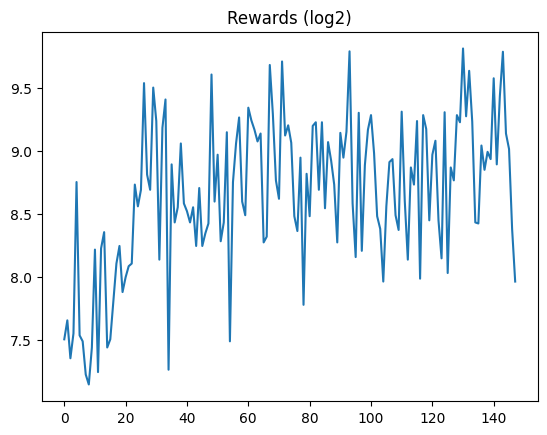

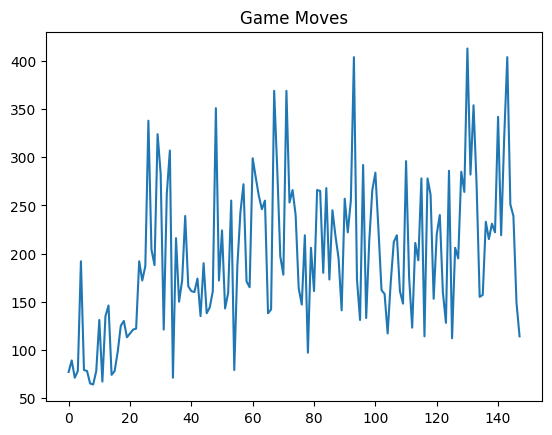

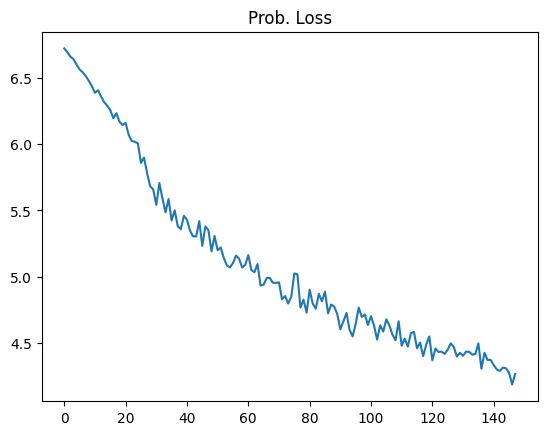

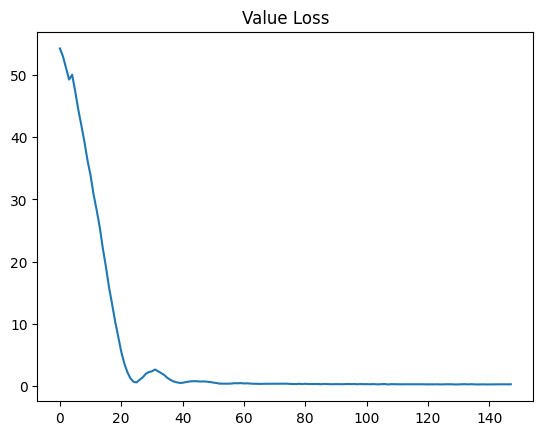

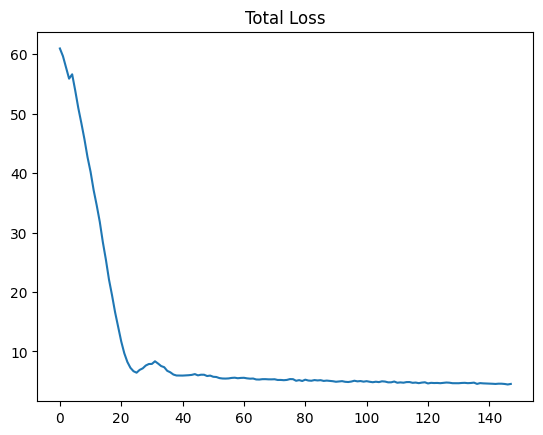

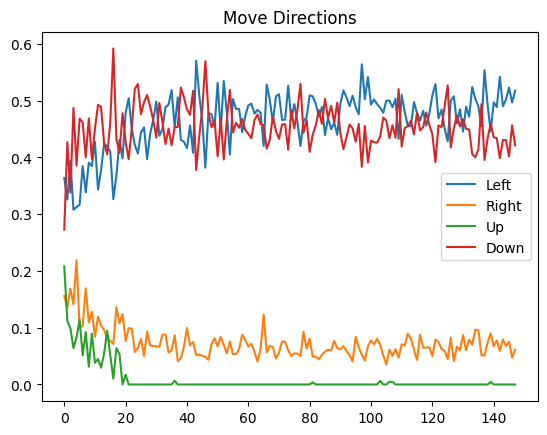

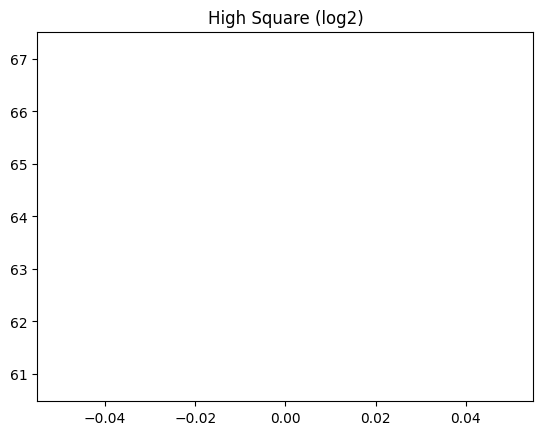

[EPISODE 147] Total Loss: 4.543977921959256, Prob Loss 4.263021504637098, Value Loss 0.2809564173221588, Reward 7.965784284662087, Moves: 114, Highest Square: 64                                         Left% 0.5175438596491229, Right% 0.06140350877192982, Up% 0.0, Down% 0.42105263157894735


KeyboardInterrupt: 

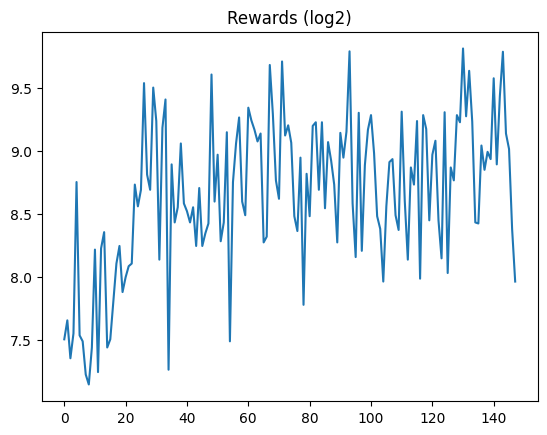

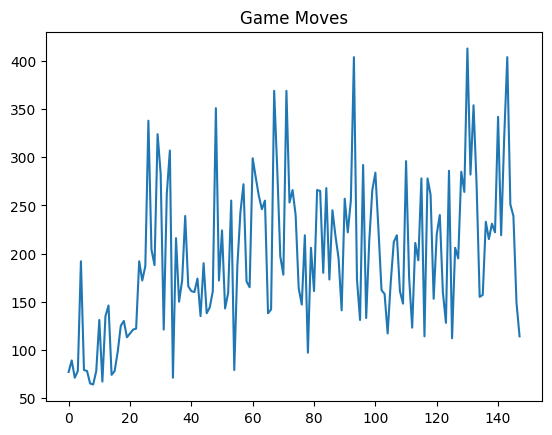

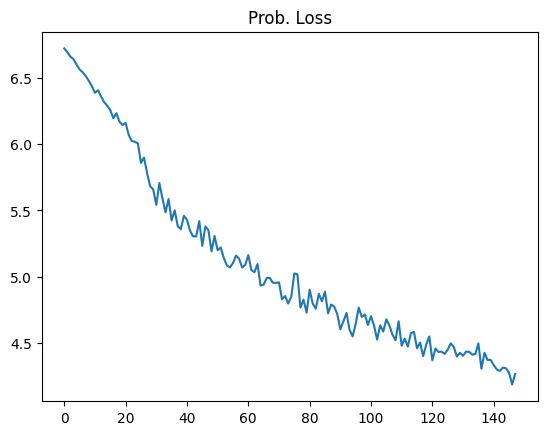

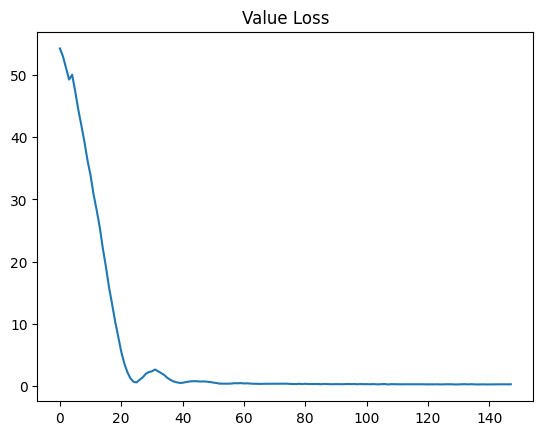

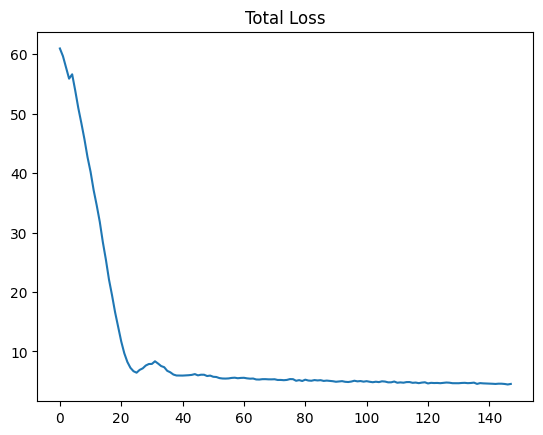

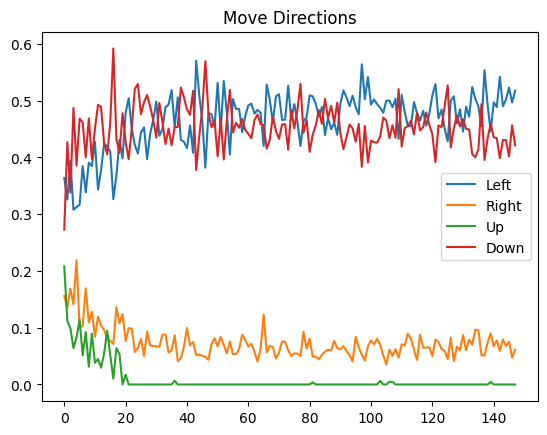

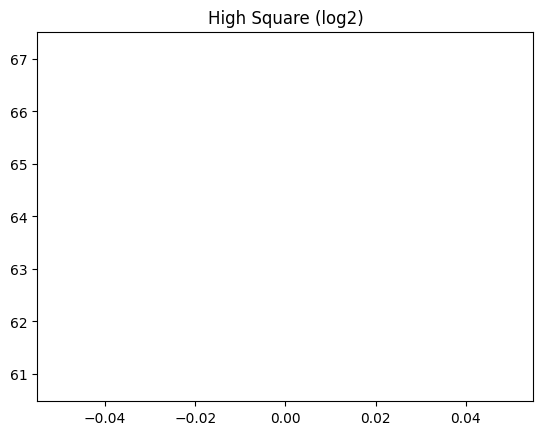

In [44]:
train_from_episode(episode, model, optimizer, env, mcts, replay_memory, metric_history, hyperparameters, run_tag)

In [38]:
metric_history.rewards

[7.507794640198696,
 7.658211482751795,
 7.357552004618084,
 7.554588851677638,
 8.754887502163468,
 7.539158811108031,
 7.491853096329675,
 7.22881869049588,
 7.149747119504682,
 7.442943495848728,
 8.219168520462162,
 7.247927513443585,
 8.228818690495881,
 8.357552004618084,
 7.442943495848728,
 7.507794640198696,
 7.807354922057604,
 8.108524456778168,
 8.247927513443585,
 7.882643049361842,
 8.0,
 8.087462841250339,
 8.108524456778168,
 8.734709620225837,
 8.562242424221072,
 8.693486957499326,
 9.539158811108031,
 8.813781191217037,
 8.693486957499326,
 9.50382573799575,
 9.238404739325079,
 8.139551352398794,
 9.184875342908283,
 9.409390936137703,
 7.266786540694901,
 8.894817763307943,
 8.434628227636725,
 8.554588851677638,
 9.060695931687555,
 8.584962500721156,
 8.523561956057012,
 8.434628227636725,
 8.554588851677638,
 8.247927513443585,
 8.707359132080883,
 8.247927513443585,
 8.348728154231077,
 8.426264754702098,
 9.60733031374961,
 8.599912842187127,
 8.97154355395077